In [11]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy import stats
import matplotlib.pyplot as plt
import random
import os
from natsort import natsorted
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from tqdm.notebook import tqdm
from scipy.stats import kruskal
import scikit_posthocs as sp

FOLDNAME="UniMiB_raw"

path  = os.path.join(os.path.curdir, FOLDNAME)
try:
    os.removedirs(os.path.join(path, ".ipynb_checkpoints"))
except:
    pass
FILES = natsorted(os.listdir(path))
N     = len(FILES)
print(N)

1980


In [2]:
def CI95(input_array):
    if type(input_array) == list:
        input_array = np.array(input_array)
    if len(input_array.shape) > 1:
        raise ValueError("Only 1-dimensional arrays can be passed to the function")

    n = len(input_array)
    z_score = 1.645  # This is true for a CI of 95%
    q = 0.5  # For the median
    lower_bound = int(np.round(n * q - z_score * np.sqrt(n * q * (1 - q))))
    upper_bound = int(np.round(n * q + z_score * np.sqrt(n * q * (1 - q))))
    
    sort_arr = np.sort(input_array)
    lower_bound = sort_arr[lower_bound]
    upper_bound = sort_arr[upper_bound]
    
    return [lower_bound, upper_bound]

In [3]:
def F1score(TARGET, RESULT):
    F1_scores = {}
    for i in range(17):
        F1_scores[i] = {"TP": 0, "FP": 0, "FN": 0}
    for R, T in zip(RESULT, TARGET):
        if R == T:
            F1_scores[R]["TP"] += 1
        else:
            F1_scores[R]["FP"] += 1
            F1_scores[T]["FN"] += 1

    all_F1 = 0.0
    for i in range(17):
        if F1_scores[i]["TP"] == 0 and F1_scores[i]["TP"] + F1_scores[i]["FN"] + F1_scores[i]["FP"] > 0:
            F1_scores[i]["F1score"] = 0.0
        elif F1_scores[i]["TP"] + F1_scores[i]["FN"] + F1_scores[i]["FP"] > 0:
            F1_scores[i]["Precision"] = F1_scores[i]["TP"] / (F1_scores[i]["TP"] + F1_scores[i]["FP"])
            F1_scores[i]["Recall"] = F1_scores[i]["TP"] / (F1_scores[i]["TP"] + F1_scores[i]["FN"])
            F1_scores[i]["F1score"] = 2 * F1_scores[i]["Precision"] * F1_scores[i]["Recall"] / (F1_scores[i]["Precision"] + F1_scores[i]["Recall"])
        else:
            F1_scores[i]["F1score"] = 1.0
        all_F1 += F1_scores[i]["F1score"]
    all_F1 /= 17
    return all_F1

### Settings for figures

In [4]:
SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALLER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

boxprops = dict(linestyle="-", linewidth=2, color="k")
medianprops = dict(linestyle="-", linewidth=4, color="k")
whiskerprops = dict(linestyle="-", linewidth=2, color="k")
capprops = dict(linestyle="-", linewidth=2, color="k")

### Here we train

In [5]:
# Train here
y = np.loadtxt("y_UniMiB_SHAR.csv").astype(int)
X = []
for file in range(0, N):     

    fileName= os.path.join(path, FILES[file])
    D = np.genfromtxt(fileName, delimiter=',')  # Data = [ X Y Z time]
    X.append(D[:, 0:3])

max_length = 3208
input_dim = 3

X_padded = np.zeros((len(X), max_length, input_dim))
for i, sample in enumerate(X):
    X_padded[i, :sample.shape[0], :] = sample

# reshape the input array to be 2D
X = X_padded.reshape((X_padded.shape[0], -1))

In [ ]:
# define the classifiers
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier(n_estimators=100)
cat_clf = CatBoostClassifier(random_seed=89, verbose=False)


# set up k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=89)

svm_scores = []
rf_scores = []
cat_scores = []
all_scores = []

svm_F1_scores = []
rf_F1_scores = []
cat_F1_scores = []
all_F1_scores = []

svm_conf_matrices = []
rf_conf_matrices = []
cat_conf_matrices = []
all_conf_matrices = []

svm_times = []
rf_times = []
cat_times = []

# perform k-fold cross-validation
for train_indices, test_indices in tqdm(skf.split(X, y), total=skf.get_n_splits(), desc="k-fold"):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train and test the classifiers
    
    # SVM
    t0 = time.time()
    svm_clf.fit(X_train, y_train)
    svm_score = svm_clf.score(X_test, y_test)
    svm_pred = svm_clf.predict(X_test)
    svm_scores.append(svm_score)
    svm_F1_scores.append(F1score(y_test, svm_clf.predict(X_test)))
    svm_confidence = np.max(svm_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_svm = t1 - t0
    
    # Random Forest
    t0 = time.time()
    rf_clf.fit(X_train, y_train)
    rf_score = rf_clf.score(X_test, y_test)
    rf_pred = rf_clf.predict(X_test)
    rf_scores.append(rf_score)
    rf_F1_scores.append(F1score(y_test, rf_clf.predict(X_test)))
    rf_confidence = np.max(rf_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_rf = t1 - t0
    
    # Catboost
    t0 = time.time()
    cat_clf.fit(X_train, y_train)
    cat_score = cat_clf.score(X_test, y_test)
    cat_pred = np.concatenate(cat_clf.predict(X_test))
    cat_scores.append(cat_score)
    cat_F1_scores.append(F1score(y_test, np.concatenate(cat_clf.predict(X_test))))
    cat_confidence = np.max(cat_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_cat = t1 - t0
    
    svm_times.append(t_svm)
    rf_times.append(t_rf)
    cat_times.append(t_cat)
    
    
    # combine the predictions
    combined_confidence = np.row_stack((svm_confidence, rf_confidence, cat_confidence))
    who_has_max_confidence = np.argmax(combined_confidence, axis=0)
    
    final_pred = []
    for w, who in enumerate(who_has_max_confidence):
        if who == 0:
            final_pred.append(svm_pred[w])
        if who == 1:
            final_pred.append(rf_pred[w])
        elif who == 2:
            final_pred.append(cat_pred[w])

    # calculate the accuracy of the combined classifier for this fold
    final_pred = np.array(final_pred)
    fold_accuracy = np.mean(final_pred == y_test)
    all_scores.append(fold_accuracy)
    all_F1_scores.append(F1score(y_test, final_pred))
    
    svm_conf = confusion_matrix(y_test, svm_pred, normalize="true")
    svm_conf_matrices.append(svm_conf)
    rf_conf = confusion_matrix(y_test, rf_pred, normalize="true")
    rf_conf_matrices.append(rf_conf)
    cat_conf = confusion_matrix(y_test, cat_pred, normalize="true")
    cat_conf_matrices.append(cat_conf)
    all_conf = confusion_matrix(y_test, final_pred, normalize="true")
    all_conf_matrices.append(all_conf)

k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# print the average accuracy across all folds for each classifier
print(f'SVM classifier accuracy: {np.mean(svm_scores):.2f} ± {np.std(svm_scores):.2f}; {np.median(svm_scores):.2f} [{CI95(svm_scores)[0]:.2f} {CI95(svm_scores)[1]:.2f}]')
print(f'Random Forest classifier accuracy: {np.mean(rf_scores):.2f} ± {np.std(rf_scores):.2f}; {np.median(rf_scores):.2f} [{CI95(rf_scores)[0]:.2f} {CI95(rf_scores)[1]:.2f}]')
print(f'Catboost classifier accuracy: {np.mean(cat_scores):.2f} ± {np.std(cat_scores):.2f}; {np.median(cat_scores):.2f} [{CI95(cat_scores)[0]:.2f} {CI95(cat_scores)[1]:.2f}]')
print(f'All classifier accuracy: {np.mean(all_scores):.2f} ± {np.std(all_scores):.2f}; {np.median(all_scores):.2f} [{CI95(all_scores)[0]:.2f} {CI95(all_scores)[1]:.2f}]')
print()

print(f'SVM F1 score: {np.mean(svm_F1_scores):.2f} ± {np.std(svm_F1_scores):.2f}; {np.median(svm_F1_scores):.2f} [{CI95(svm_F1_scores)[0]:.2f} {CI95(svm_F1_scores)[1]:.2f}]')
print(f'Random Forest F1 score: {np.mean(rf_F1_scores):.2f} ± {np.std(rf_F1_scores):.2f}; {np.median(rf_F1_scores):.2f} [{CI95(rf_F1_scores)[0]:.2f} {CI95(rf_F1_scores)[1]:.2f}]')
print(f'Catboost F1 score: {np.mean(cat_F1_scores):.2f} ± {np.std(cat_F1_scores):.2f}; {np.median(cat_F1_scores):.2f} [{CI95(cat_F1_scores)[0]:.2f} {CI95(cat_F1_scores)[1]:.2f}]')
print(f'All F1 score: {np.mean(all_F1_scores):.2f} ± {np.std(all_F1_scores):.2f}; {np.median(all_F1_scores):.2f} [{CI95(all_F1_scores)[0]:.2f} {CI95(all_F1_scores)[1]:.2f}]')
print()

print(f'SVM times [s]: {np.mean(svm_times):.2f} ± {np.std(svm_times):.2f}; {np.median(svm_times):.2f} [{CI95(svm_times)[0]:.2f} {CI95(svm_times)[1]:.2f}]')
print(f'Random Forest times [s]: {np.mean(rf_times):.2f} ± {np.std(rf_times):.2f}; {np.median(rf_times):.2f} [{CI95(rf_times)[0]:.2f} {CI95(rf_times)[1]:.2f}]')
print(f'Catboost times [s]: {np.mean(cat_times):.2f} ± {np.std(cat_times):.2f}; {np.median(cat_times):.2f} [{CI95(cat_times)[0]:.2f} {CI95(cat_times)[1]:.2f}]')

SVM classifier accuracy: 0.48 ± 0.04; 0.49 [0.44 0.53]
Random Forest classifier accuracy: 0.55 ± 0.04; 0.56 [0.51 0.59]
Catboost classifier accuracy: 0.56 ± 0.04; 0.55 [0.54 0.61]
All classifier accuracy: 0.56 ± 0.04; 0.55 [0.55 0.60]

SVM F1 score: 0.51 ± 0.04; 0.51 [0.48 0.55]
Random Forest F1 score: 0.57 ± 0.04; 0.57 [0.55 0.62]
Catboost F1 score: 0.59 ± 0.04; 0.60 [0.55 0.64]
All F1 score: 0.59 ± 0.05; 0.60 [0.55 0.62]

SVM times [s]: 194.10 ± 30.32; 208.47 [194.70 212.18]
Random Forest times [s]: 5.34 ± 0.73; 5.49 [4.68 5.95]
Catboost times [s]: 1721.02 ± 375.91; 1862.31 [1848.30 2008.24]


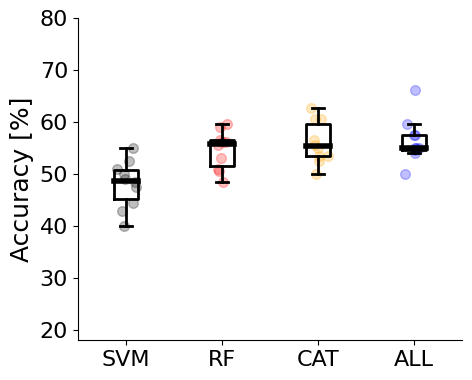

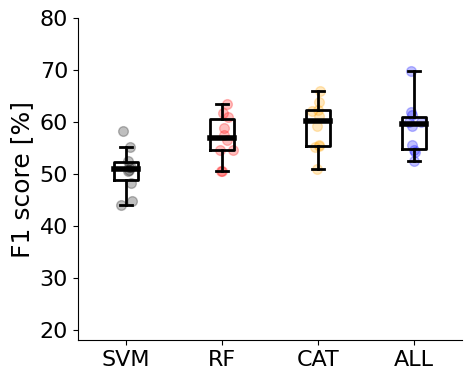

In [13]:
scores = {"SVM": svm_scores, "RF": rf_scores, "CAT": cat_scores, "ALL": all_scores}
F1_scores = {"SVM": svm_F1_scores, "RF": rf_F1_scores, "CAT": cat_F1_scores, "ALL": all_F1_scores}
markers = ["o", "o", "o", "o"]
colors = ["black", "red", "orange", "blue"]

fig = plt.figure(figsize=(5, 4))
for m, model in enumerate(["SVM", "RF", "CAT", "ALL"]):
    accuracies = np.array(scores[model]) * 100.0
    plt.plot(np.random.normal(m, 0.05, len(accuracies)), accuracies, color=colors[m], alpha=0.25, ms=7, marker=markers[m], linestyle="None", label=model)
    
    dataframe = pd.DataFrame(accuracies)
    dataframe.boxplot(positions=[m], patch_artist=False, widths=(0.25),
                      boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
                      showfliers=False, grid=False, ax=plt.gca())

plt.ylabel("Accuracy [%]")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.box("off")
plt.xticks(range(4), labels=["SVM", "RF", "CAT", "ALL"])
plt.tight_layout()
plt.ylim(18, 80)

plt.savefig("acc_raw_UniMiB.png", dpi=900)

fig = plt.figure(figsize=(5, 4))
for m, model in enumerate(["SVM", "RF", "CAT", "ALL"]):
    accuracies = np.array(F1_scores[model]) * 100.0
    plt.plot(np.random.normal(m, 0.05, len(accuracies)), accuracies, color=colors[m], alpha=0.25, ms=7, marker=markers[m], linestyle="None", label=model)
    
    dataframe = pd.DataFrame(accuracies)
    dataframe.boxplot(positions=[m], patch_artist=False, widths=(0.25),
                      boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
                      showfliers=False, grid=False, ax=plt.gca())

plt.ylabel("F1 score [%]")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.box("off")
plt.xticks(range(4), labels=["SVM", "RF", "CAT", "ALL"])
plt.tight_layout()
plt.ylim(18, 80)
plt.savefig("F1_raw_UniMiB.png", dpi=900)

plt.show()

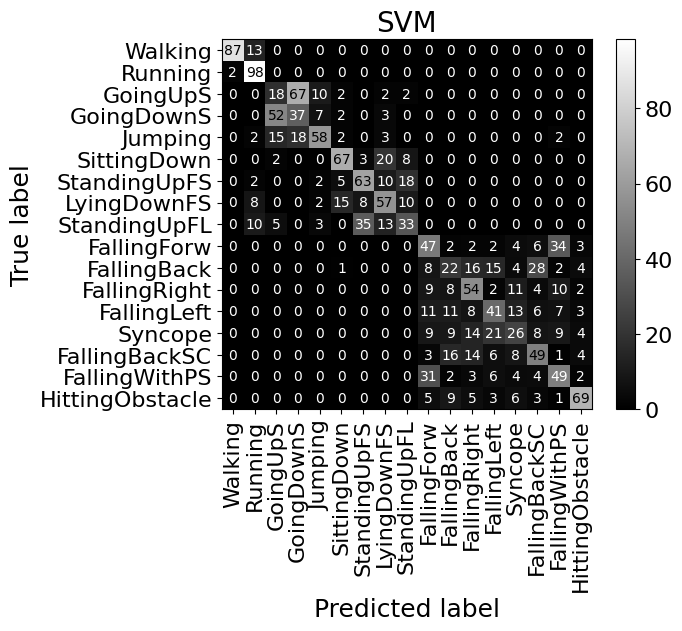

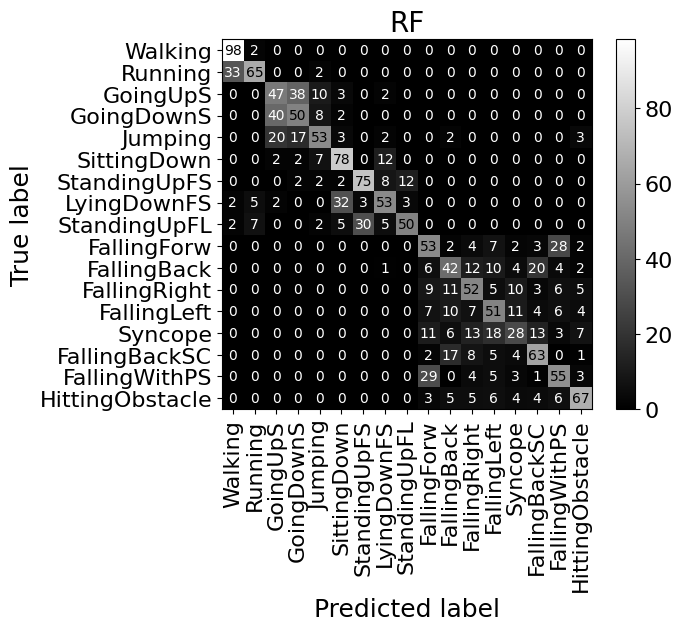

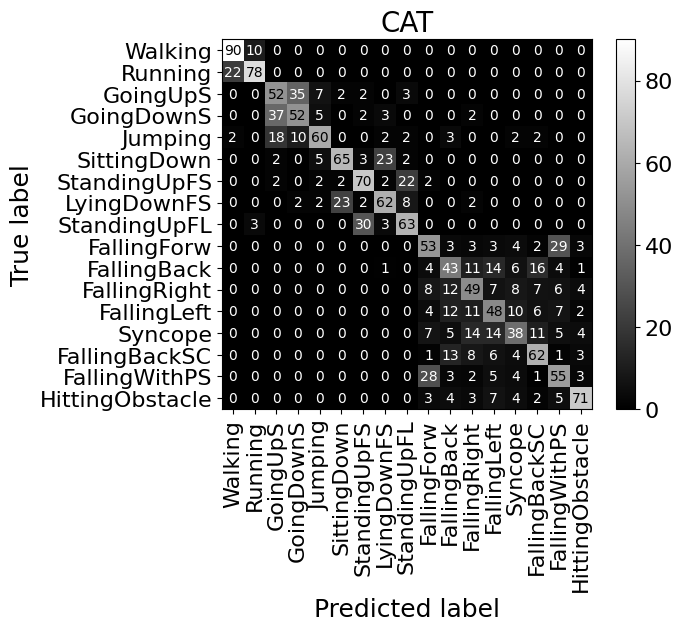

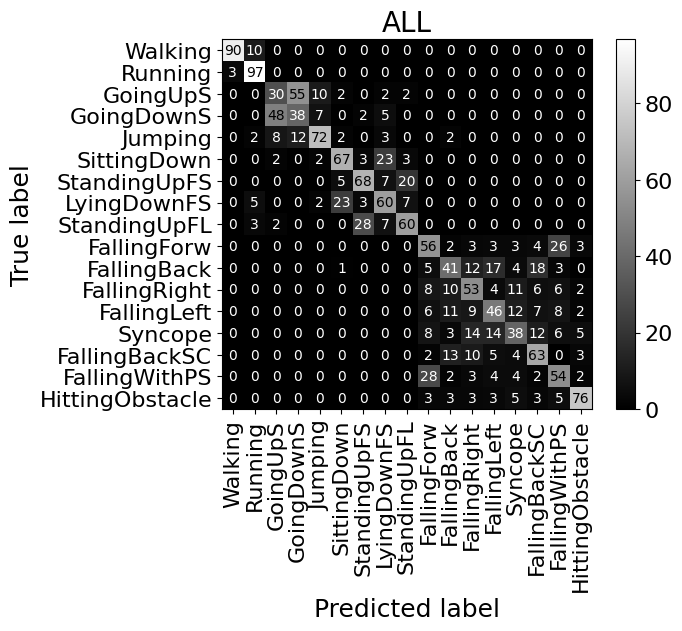

In [14]:
classes = ['Walking','Running','GoingUpS','GoingDownS','Jumping','SittingDown','StandingUpFS','LyingDownFS','StandingUpFL','FallingForw','FallingBack','FallingRight','FallingLeft','Syncope','FallingBackSC','FallingWithPS','HittingObstacle']

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(svm_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f", xticks_rotation=90)
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("SVM")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(rf_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f", xticks_rotation=90)
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("RF")
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cat_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f", xticks_rotation=90)
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("CAT")
plt.savefig("Confusion_CAT_raw_UniMiB.png", dpi=900)
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(all_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f", xticks_rotation=90)
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("ALL")
plt.show()